In [9]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy import stats, interpolate
from scipy.ndimage import gaussian_filter1d

plt.rcParams["axes.linewidth"]  = 1.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)

import os, sys
if os.environ['USER'] == 'dhayaa':
    os.environ['PATH'] = f"{os.environ['PATH']}:/software/texlive-2021-el7-x86_64/bin/x86_64-linux"
    
    
COLORS = ["f07167","219ebc","c767ac", "59a270", "ffba0a"]
COLORS = ['#' + c if c[0] != '#' else c for c in COLORS ]

from cycler import cycler

# Update the default prop_cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=COLORS)

# Load data

In [10]:
sys.path.insert(0, '/home/dhayaa/Desktop/DECADE/')
from CosmicShearPhotoZ.Likelihood import WZLikelihoodRunner

In [22]:
min_z   = 0.01
max_z   = 5
delta_z = 0.05
zbins   = np.arange(min_z,max_z+delta_z,delta_z)
zbinsc  = zbins[:-1]+(zbins[1]-zbins[0])/2.

files = sorted(glob.glob('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20241113/Final/nz_Samp*.npy'))
X  = np.concatenate([np.load(f) for f in files]) / delta_z

meanz = np.mean(X, axis = 0)
covz  = np.array([np.cov(X[:, i, :].T) for i in range(X.shape[1])])
colors2 =['C0', 'C1', 'C2', 'C3']

In [23]:
#Read out the WZ measurements
WZ_data = np.load('/project/chihway/dhayaa/DECADE/Wz/20240726_fiducial_Wz_600patch_urmask_CovMat.npy', allow_pickle = True)[()]

# The params of the non-sys func marginalization
b_u           = 1
b_u_sigma     = 6
alpha_u       = 1.9 - 2
alpha_u_sigma = 4

# Now the sys function marginalization
var   = 0.15**2
M     = 5
s_mu  = np.zeros(M + 1)
s_var = np.ones(M + 1)
s_var[0]  *= np.log(b_u_sigma/b_u + 1)**2
s_var[1:] *= var

# Magnification coefficients (taking from section 3.3 of https://arxiv.org/pdf/2012.08569)

z_RM = [0.25, 0.425, 0.575, 0.75, 0.9]
#a_RM = [0.313, -1.515, -0.6628, 1.251, 0.9685]
a_RM = [2.63, -1.04, 0.67, 4.50, 3.93]

z_ML = [0.3, 0.475, 0.625, 0.775, 0.9, 1.0]
a_ML = [2.43, 2.30, 3.75, 3.94, 3.56, 4.96]

alpha_r = interpolate.interp1d(z_RM, a_RM, kind = 'cubic', fill_value = (a_RM[0], a_RM[-1]), bounds_error = False)

#HARDCODED VALUES; MEASUREMENTS OF WZ
R_min  = 1.5
R_max  = 5.0
R_bins = 10
print(f"USING R_min = {R_min}, R_max = {R_max}, and R_bins = {R_bins}")

#HARDCODED VALUES; MEASUREMENTS OF NZ
min_z   = 0.01
max_z   = 5
delta_z = 0.05
zbins   = np.arange(min_z,max_z+delta_z,delta_z)
zbinsc  = zbins[:-1]+(zbins[1]-zbins[0])/2.
zmsk    = np.zeros_like(zbinsc).astype(bool)
zfit    = np.zeros_like(zbinsc).astype(bool)
#     zmsk[2:26] = True #Which parts of n(z) have Wz measurements to them.
N = 30
zfit[2:2+N] = True #Which parts of n(z) have Wz measurements to them.
zmsk[2:2+N] = True #Which parts of n(z) have Wz measurements to them.

#Loop back to interpolate the z_bins and add the surface area factor (alpha = -2)
#Can only evaluate this for redshift where we have boss galaxy data
alpha_r = alpha_r(zbinsc[zmsk])

print("ZBINS:", zbinsc[zfit])
print("ALPHA:", alpha_r)

USING R_min = 1.5, R_max = 5.0, and R_bins = 10
ZBINS: [0.135 0.185 0.235 0.285 0.335 0.385 0.435 0.485 0.535 0.585 0.635 0.685
 0.735 0.785 0.835 0.885 0.935 0.985 1.035 1.085 1.135 1.185 1.235 1.285
 1.335 1.385 1.435 1.485 1.535 1.585]
ALPHA: [ 2.63        2.63        2.63        1.25662999 -0.11004284 -0.84825536
 -1.03786776 -0.75874027 -0.09073308  0.88614397  2.06015772  3.24879618
  4.2599705   4.90159182  4.98157132  4.30782012  3.93        3.93
  3.93        3.93        3.93        3.93        3.93        3.93
  3.93        3.93        3.93        3.93        3.93        3.93      ]


In [24]:
res = []
for i in range(4):

    WZ     = WZ_data['w_ur'][i][:N]
    C_Wz   = WZ_data['Cw_ur'][i][:][:N, :N]
    b_r    = WZ_data['b_z'][i][:N]

    #Hardcoded hartlap factor, for now....
    Njk   = 600
    Ndata = C_Wz.shape[0]
    hartlap  = (Njk - Ndata)/(Njk -1)
    dodelson = 1 / (1 + (Ndata - 3) * (Njk - Ndata - 2) / (Njk - Ndata - 1) / (Njk - Ndata - 4) )

    print(f"APPLYING HARTLAP {hartlap}, AND DODELSON {dodelson} TO BIN {i}. COMBINED {hartlap * dodelson}")

    C_Wz   = C_Wz / (hartlap * dodelson)

    #The Runner
    Runner = WZLikelihoodRunner(Wz  = WZ, z = zbinsc, zmsk = zmsk, zfit = zfit, C_Wz = C_Wz, 
                                b_r = b_r, alpha_r = alpha_r,
                                s_mu  = s_mu, s_sig = np.sqrt(s_var), 
                                b_u = b_u, b_u_sig = b_u_sigma,
                                alpha_u = alpha_u, alpha_u_sig = alpha_u_sigma,
                                R_min   = R_min, R_max = R_max, R_bins = R_bins,
                                lnlk_tolerance = 0.01, Niter = 100)

    Runner.C_nz = np.cov(X[:, i].T)
    res.append(Runner.get_loglike(meanz[i], return_A = True))

APPLYING HARTLAP 0.9515859766277128, AND DODELSON 0.9545451850973651 TO BIN 0. COMBINED 0.9083318121961571


Build Dij matrix: 100%|██████████| 100/100 [00:05<00:00, 16.79it/s]


APPLYING HARTLAP 0.9515859766277128, AND DODELSON 0.9545451850973651 TO BIN 1. COMBINED 0.9083318121961571


Build Dij matrix: 100%|██████████| 100/100 [00:06<00:00, 16.43it/s]


APPLYING HARTLAP 0.9515859766277128, AND DODELSON 0.9545451850973651 TO BIN 2. COMBINED 0.9083318121961571


Build Dij matrix: 100%|██████████| 100/100 [00:05<00:00, 16.77it/s]


APPLYING HARTLAP 0.9515859766277128, AND DODELSON 0.9545451850973651 TO BIN 3. COMBINED 0.9083318121961571


Build Dij matrix: 100%|██████████| 100/100 [00:06<00:00, 16.61it/s]


In [7]:
# for i in range(8):
#     plt.figure(figsize = (5,5))
#     plt.hist(Likelihood[:, 3, 2:10][:, i], bins = 100)
#     plt.show()

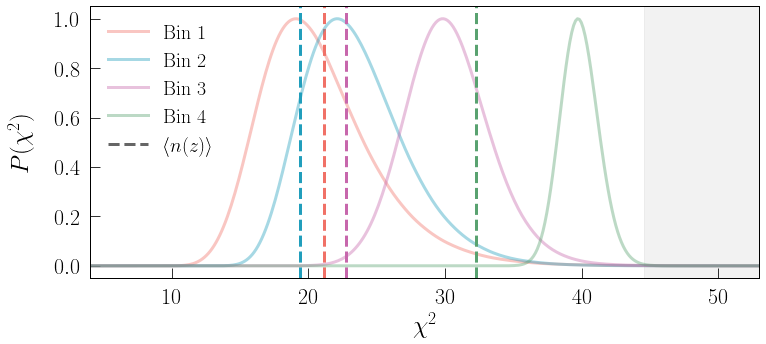

In [25]:
Likelihood  = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20241113/Final/LnLikelihood_Fiducial_HighUncert_balpha_u_all_N30_RM_V2.npy')

plt.figure(figsize = (12,5))
for i in range(4):
    
    X, bins = np.histogram(Likelihood[:, i, 1], bins = 1000, range = (0, 140))
    bins = (bins[1:] + bins[:-1])/2
    dX   = bins[1] - bins[0]
    X = gaussian_filter1d(X, 0.5/dX)
    X = X/np.max(X)
    plt.plot(bins, X, lw = 3, label = 'Bin %d' % (i + 1), color = 'C%d' % i, alpha = 0.4);
    avg  = np.average(Likelihood[:, i, 1] < stats.chi2(30 - 8).ppf(0.997))
#     plt.text(0.94, 0.85 - 0.11*i, r'%0.1f' % (avg*100) + r'\%', fontsize = 22, color = 'C%d' % i, 
#              transform = plt.gca().transAxes, ha = 'right')
    
    plt.axvline(res[i][0][1], color = f'C{i}', ls = '--', lw = 3)
    
    
plt.plot([], [], ls = '--', color = 'k', lw = 3, label = r'$\langle n(z) \rangle$', alpha = 0.6)
    
plt.legend(fontsize = 20)

# plt.axvline(stats.chi2(40).ppf(0.997), color = 'k', lw = 2, ls = '--', zorder = -100)
plt.axvspan(stats.chi2(30 - 8).ppf(0.997), 90, color = 'k', alpha = 0.05)
plt.xlabel(r'$\chi^2$', size = 25)
plt.ylabel(r'$P(\chi^2)$', size = 25, labelpad = 20)

plt.xlim(4, 53)

plt.tick_params(which = 'both', pad = 10)
plt.savefig('./SOMPZ_WZ_chi2.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

In [26]:
!pwd

/home/dhayaa/Desktop/DECADE/CosmicShearPhotoZ/paper_plots


In [19]:
stats.norm().ppf(1 - stats.chi2(22).cdf(24))

-0.39281133098258153

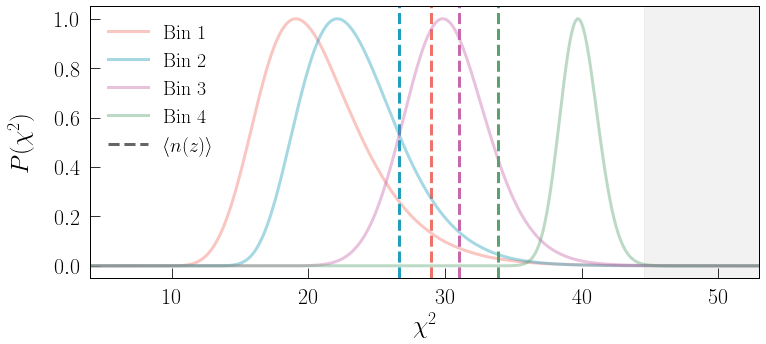

In [14]:
Likelihood  = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20241113/Final/LnLikelihood_Fiducial_HighUncert_balpha_u_all_N30_RM_V2.npy')

plt.figure(figsize = (12,5))
for i in range(4):
    
    X, bins = np.histogram(Likelihood[:, i, 1], bins = 1000, range = (0, 140))
    bins = (bins[1:] + bins[:-1])/2
    dX   = bins[1] - bins[0]
    X = gaussian_filter1d(X, 0.5/dX)
    X = X/np.max(X)
    plt.plot(bins, X, lw = 3, label = 'Bin %d' % (i + 1), color = 'C%d' % i, alpha = 0.4);
    avg  = np.average(Likelihood[:, i, 1] < stats.chi2(30 - 8).ppf(0.997))
#     plt.text(0.94, 0.85 - 0.11*i, r'%0.1f' % (avg*100) + r'\%', fontsize = 22, color = 'C%d' % i, 
#              transform = plt.gca().transAxes, ha = 'right')
    
    plt.axvline(res[i][0][1], color = f'C{i}', ls = '--', lw = 3)
    
    
plt.plot([], [], ls = '--', color = 'k', lw = 3, label = r'$\langle n(z) \rangle$', alpha = 0.6)
    
plt.legend(fontsize = 20)

# plt.axvline(stats.chi2(40).ppf(0.997), color = 'k', lw = 2, ls = '--', zorder = -100)
plt.axvspan(stats.chi2(30 - 8).ppf(0.997), 90, color = 'k', alpha = 0.05)
plt.xlabel(r'$\chi^2$', size = 25)
plt.ylabel(r'$P(\chi^2)$', size = 25, labelpad = 20)

plt.xlim(4, 53)

plt.tick_params(which = 'both', pad = 10)
plt.savefig('./SOMPZ_WZ_chi2.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

In [16]:
min_z   = 0.01
max_z   = 5
delta_z = 0.05
zbins   = np.arange(min_z,max_z+delta_z,delta_z)
zbinsc  = zbins[:-1]+(zbins[1]-zbins[0])/2.


files = sorted(glob.glob('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20241113/Final/nz_Samp*.npy'))
X  = np.concatenate([np.load(f) for f in files]) / delta_z

colors2 =['C0', 'C1', 'C2', 'C3']

Likelihood  = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20241113/Final/LnLikelihood_Fiducial_all_N30_RM_V2.npy')
max_like    = np.min(Likelihood[..., 0], axis = 0)
good        = np.abs(Likelihood[..., 0] - max_like) < stats.chi2.ppf(stats.norm.cdf(5), 8)

Z  = np.load('/project/chihway/dhayaa/DECADE/Wz/20240726_fiducial_Wz_600patch_urmask_CovMat.npy', allow_pickle = True)[()]
z = np.linspace(0.1, 2.1, 40 + 1)
z = (z[1:] + z[:-1])/2

dz1 = delta_z
dz3 = z[1] - z[0]